# Doctoplant - Discover diseases on leaves photos.

## Iteration 2bis:
1. Random Background

## 1. Environment preparation
1. Make sure TensorFlow is installed 
2. Check if Drive is connected
3. Unzip dataset
4. Check if we are connected to GPU

It's faster to copy the Dataset from our own Drive to Collab environment. And from there, unzip the Dataset and start working on it.

It takes overall less than 5 minutes to copy and unzip the whole Dataset, so it worth it to follow this process.

In [ ]:
# Import TensorFlow into collab
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.4.1


In [ ]:
# Import Drive (to execute only ONCE)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip Background images (to execute only ONCE)
!unzip -u '/content/sample_data/bckgrnd_img.zip' -d '/content/sample_data'
# Unzip Dataset (to execute only ONCE)
!unzip -u "/content/sample_data/plantvillage_dataset_augmented_fixed.zip" -d "/content/sample_data"
# Unzip Test Datset
!unzip -u "/content/sample_data/dataset_test_final.zip" -d "/content/sample_data"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im41336.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im40996.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im40996.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im41450.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im41450.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im43247.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im43247.jpg  
  inflating: /content/sample_data/plantvillage_dataset_augmented/Soybean___healthy/im42159.jpg  
  inflating: /content/sample_data/__MACOSX/plantvillage_dataset_augmented/Soybean___healthy/._im42159.

### Use of GPU

For the purpose of Image Classification, we will use Google GPU to allow us to use Google resources. This will help us to considerably improve the capacity of the laptop to execute ML programs.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 2. Code - preparation and training CNN

As we have already performed the DataViz and Data Exploration, we can directly work on our CNN model.
We need:
1. Import the required libraries
2. Create a DataFrame with all information
3. Prepare Data (train/validation)
4. Create Datasets
5. Create CNN model
6. Train our model


### 1. Import the required libraries

In [ ]:
# Import required packages
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Create DataFrame 

We will create DataFrame to store required information for our script.

Dataframe composed of:
- List of Plants name (plant)
- List of Plants Categories (category)
- List of images path (img_path) > Features
- List of Plants name + Plants Categories (plant___category) > Labels
- Background of the leaves plant. For other Category no background is required (back_path)

In [ ]:
import glob
# Get Path to Image folders
IMG_PATH = '/content/sample_data/plantvillage_dataset_augmented'
BCK_PATH = '/content/sample_data/bckgrnd_img'
BCK_FILES = {root: files for root, _, files in os.walk(BCK_PATH)}

# Image size
IMG_SIZE = 128
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
OUTPUT_SHAPE = 39
BUFFER_SIZE = 1000
BATCH_SIZE = 32
NUM_EPOCHS = 20

In [ ]:
def get_random_bckg(plant):
  bckgrd_img_path = BCK_PATH +'/'+plant
  bckgrd_img = np.random.choice(BCK_FILES[bckgrd_img_path])

  return os.path.join(bckgrd_img_path, bckgrd_img)


# Create Dataframe
def create_info_df(dir_path):

  list_plants = []
  img_listdir = glob.glob(os.path.join(dir_path, '*'))

  for img_dir in img_listdir:
    plant = img_dir.split('/')[-1]

    for img in os.listdir(img_dir):
      list_plants.append([*plant.split('___'), os.path.join(img_dir,img), plant])

  df = pd.DataFrame(list_plants, columns=['plant', 'category', 'img_path','plant___category'])
  df['back_path'] = df['plant'].apply(lambda x: x if x == 'Others' else get_random_bckg(x))

  return df

# Get DF
df_info = create_info_df(IMG_PATH)
print("DF Info shape: ", df_info.shape)

# Unique label list:
unique_plant_cat = np.unique(df_info['plant___category'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))
list_class = unique_plant_cat.tolist()

# Label Integer
df_info['label_int'] = df_info['plant___category'].apply(lambda x: list_class.index(x))

DF Info shape:  (114077, 5)
Number of Categories to predict:  39


In [ ]:
unique_plant_cat

array(['Apple___Apple_scab', 'Apple___Black_rot',
       'Apple___Cedar_apple_rust', 'Apple___healthy',
       'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew',
       'Cherry_(including_sour)___healthy',
       'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
       'Corn_(maize)___Common_rust_',
       'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
       'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
       'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
       'Orange___Haunglongbing_(Citrus_greening)', 'Others___Others',
       'Peach___Bacterial_spot', 'Peach___healthy',
       'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
       'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch',
       'Strawberry___healthy', 'Tomato___Bacterial_spot',
       'Tomato___Early_blight', 'Tomato_

In [ ]:
df_info.head()

,plant,category,img_path,plant___category,back_path,label_int
0,Grape,Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/plantvillage_dataset_augm...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/bckgrnd_img/Grape/Grape4.jpg,13
1,Grape,Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/plantvillage_dataset_augm...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/bckgrnd_img/Grape/Grape5.jpg,13
2,Grape,Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/plantvillage_dataset_augm...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/bckgrnd_img/Grape/Grape5.jpg,13
3,Grape,Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/plantvillage_dataset_augm...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/bckgrnd_img/Grape/Grape5.jpg,13
4,Grape,Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/plantvillage_dataset_augm...,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),/content/sample_data/bckgrnd_img/Grape/lawn.jpg,13


In [ ]:
df_info['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Others___Others                                       5000
Tomato___Late_blight                                  3818
Squash___Powdery_mildew                               3670
Tomato___Septoria_leaf_spot                           3542
Tomato___Spider_mites Two-spotted_spider_mite         3352
Apple___healthy                                       3290
Tomato___healthy                                      3182
Blueberry___healthy                                   3004
Potato___Early_blight                                 3000
Potato___Late_blight                                  3000
Tomato___Early_blight                                 3000
Pepper,_bell___Bacterial_spot                         2991
Pepper,_bell___healthy                                2956
Corn_(maize)___Northern_Leaf_Blight                   29

### 3. Prepare Data

Functions utils

In [ ]:
# Functions
LIST_CLASS_LEN = len(list_class)

# Split DataFrame into 2 DataFrame - Validation and Training DataFrame
def split_data(df):
  """
    Get Dataframe and split it in Train and Validation DataFrame.
    Train: 80% of full data
    Validation: 20% of Data
  """
  df = df.sample(frac=1, random_state=42).reset_index()
  split_size = round(len(df)*80/100)
  train = df.iloc[:split_size]
  valid = df.iloc[split_size:]

  return train, valid


def decode_img(path, label, back, image_shape=IMG_SHAPE):
  """
    Read image from `path`, and convert the image to a 3D tensor
    return resized image.
    return: resized tensor image and label
  """
  # Threshold for background
  threshold = 10

  # Read the image file
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, image_shape[:2]) # Resize image to our desired size

  # Transform label integer to one hot vector
  label_one_hot = tf.one_hot(label,depth=LIST_CLASS_LEN)

  if back == 'Others':
    return tf.cast(img, tf.float32)/255, label_one_hot

  # Else, we get the Background path, and add it to the leaf image
  bkg = tf.io.read_file(back)
  bkg = tf.image.decode_jpeg(bkg, channels=3)
  bkg = tf.image.resize(bkg, image_shape[:2]) # Resize image to our desired size

  # If pixel < threshold (ie=black background)
  # use pixel from backgound image, else use pixel of image (the leaf)
  n_img = tf.where(tf.image.rgb_to_grayscale(img) < threshold, bkg, img)

  # Normalize image (cast float32 and image pixel between 0-1)
  return tf.cast(n_img, tf.float32)/255, label_one_hot


def create_dataset(datapoint, valid_data=False):
  X, y, back = datapoint['img_path'], datapoint['label_int'], datapoint['back_path']

  # For Validation set - We do not shuffle
  if valid_data:
    print('Creation of the validation dataset...')
    dataset = tf.data.Dataset.from_tensor_slices((X, y, back))
    dataset = dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  # For Training set
  else:
    print('Creation of the Training dataset...')
    dataset = tf.data.Dataset.from_tensor_slices((X, y, back))
    dataset = dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset


# Save and load model
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in ad models directory and appends a suffix (string).
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join("drive/My Drive/DataScientest/30 - Models/saved_models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M"))
    model_path = modeldir + "-" + suffix + ".h5" #save format of model
    print(f"Save model to: {model_path}...")
    model.save(model_path)
    return model_path

# Create a function to load a model
def load_model(model_path):
    """
    Load a saved model from a specify path
    """
    print(f"Loading saved model from: {model_path}...")
    model = tf.keras.models.load_model(model_path)
    return model

def display_imgs(display_list, label=None):
  plt.figure(figsize=(16,16))

  labels = ['Image '+label, 'Background', ' Image with Background']

  for i, data in enumerate(display_list):
    plt.subplot(1,len(display_list)+1, i+1)
    plt.imshow(np.squeeze(data).astype('uint8'))
    # plt.imshow(tf.keras.preprocessing.image.array_to_img(data))
    plt.title(labels[i])
    plt.axis('off')
  plt.show()

The Dataset is a leaf image with Black background.
To help the model recognize a leaf from a photo taken in a natural environment, we will add a backgound (of a plants) in each images.

This process will be done "*on the fly*" to avoid creating a new dataset.

The process is as follow:
- Take the leaf image with black background and convert it to an array.
> When the image is converted to an array, a black pixel is represented by 0.
- For every pixel (converted to a number) below a chosen threshold, replace the pixel with the pixel from the backgound image.
> we use `tf.where(pixel_img < threshold, pixel_backgrnd, pixel_img)`. We can translate it as: 
> - if **pixel_image** is below **threshold**, use **pixel_backgrnd**
> - else, use **pixel_img**

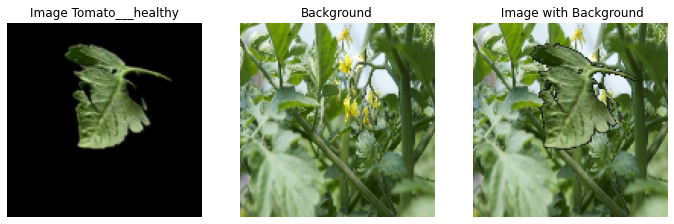

In [ ]:
# Let's see an example:
random = np.random.randint(0, len(df_info))

def get_img_bck(img_path, bckgrnd_path):
  # Threshold for background
  threshold = 10
  # Read the image file
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  # Resize image to our desired size
  img = tf.image.resize(img, IMG_SHAPE[:2])

  bkg = tf.io.read_file(bckgrnd_path)
  bkg = tf.image.decode_jpeg(bkg, channels=3)
  # Resize image to our desired size
  bkg = tf.image.resize(bkg, IMG_SHAPE[:2])
  # If pixel < threshold (ie=black background)
  # use pixel from backgound image, else use pixel of image (the leaf)
  n_img = tf.where(tf.image.rgb_to_grayscale(img) < threshold, bkg, img)

  # Normalize image (cast float32 and image pixel between 0-1)
  return img, bkg, n_img

imgs_list = list(get_img_bck(df_info.iloc[random]['img_path'], df_info.iloc[random]['back_path']))

display_imgs(imgs_list, df_info.iloc[random]['plant___category'])

Split Data to Validation set and Train set.

In [ ]:
train, valid = split_data(df_info)
print("Train df shape: ", train.shape)
print("Valid df shape: ", valid.shape)

Train df shape:  (91262, 7)
Valid df shape:  (22815, 7)


In [ ]:
train['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              4420
Tomato___Tomato_Yellow_Leaf_Curl_Virus                4293
Soybean___healthy                                     4041
Others___Others                                       3960
Tomato___Late_blight                                  3028
Squash___Powdery_mildew                               2969
Tomato___Septoria_leaf_spot                           2851
Tomato___Spider_mites Two-spotted_spider_mite         2673
Apple___healthy                                       2629
Tomato___healthy                                      2510
Tomato___Early_blight                                 2453
Potato___Late_blight                                  2423
Pepper,_bell___Bacterial_spot                         2403
Potato___Early_blight                                 2402
Blueberry___healthy                                   2384
Pepper,_bell___healthy                                2354
Corn_(maize)___Northern_Leaf_Blight                   23

In [ ]:
valid['plant___category'].value_counts()

Orange___Haunglongbing_(Citrus_greening)              1087
Tomato___Tomato_Yellow_Leaf_Curl_Virus                1064
Soybean___healthy                                     1049
Others___Others                                       1040
Tomato___Late_blight                                   790
Squash___Powdery_mildew                                701
Tomato___Septoria_leaf_spot                            691
Tomato___Spider_mites Two-spotted_spider_mite          679
Tomato___healthy                                       672
Apple___healthy                                        661
Corn_(maize)___Northern_Leaf_Blight                    635
Blueberry___healthy                                    620
Tomato___Leaf_Mold                                     605
Pepper,_bell___healthy                                 602
Potato___Early_blight                                  598
Pepper,_bell___Bacterial_spot                          588
Potato___Late_blight                                   5

### 4. Create Datasets

In [ ]:
dataset_train = create_dataset(train)
dataset_valid = create_dataset(valid, valid_data=True)

Creation of the Training dataset...
Creation of the validation dataset...


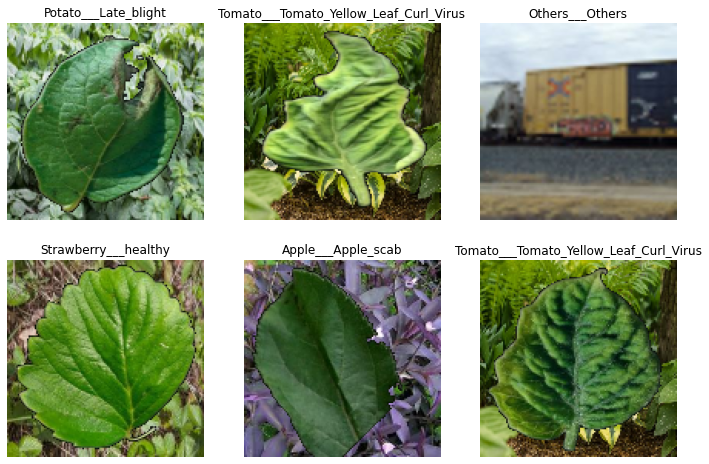

In [ ]:
# Check if records are well created in datasets
img_batch, label_batch = next(iter(dataset_train))

plt.figure(figsize=(12, 8))
for i in range(6):
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow((img_batch[i].numpy()*255).astype("uint8"))
  label = np.argmax(label_batch[i])
  plt.title(unique_plant_cat[label])
  plt.axis("off")

### 5. Create CNN model



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D

regularizer = tf.keras.regularizers.l2(5e-3)
INPUT_SHAPE = IMG_SHAPE

# Create model
# 4 conv2D layers
# Batch Normalisation and MaxPooling
def get_model():
  """
  Create a 4 Conv2D layers with
    - Batch Normalisation
    - MaxPooling
    - ReLU activation
  And 2 Dense layers ReLU activation (and Dropout)
  
  Return 39 probabilities (= number of plants + other category we want to predict) - activation Softmax
  """

  model = Sequential([
    # First CNN                     
    Conv2D(128, kernel_size=3, input_shape=INPUT_SHAPE, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    # Second CNN
    Conv2D(256, kernel_size=3, activation='relu'),   
    MaxPooling2D(),
    BatchNormalization(),
    # Third CNN
    Conv2D(512, kernel_size=3, activation='relu'), 
    MaxPooling2D(),
    BatchNormalization(),
    
    # Flatten last CNN output for Dense layers
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    # Return 39 probabilities (= number of plants we want to predict)
    Dense(OUTPUT_SHAPE, activation= 'softmax')
  ])

  return model

model = get_model()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show Summary 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 512)       1

We will create two Callbacks:
- **Early stopping**: to stop training of the model if the validation accuracy is not moving down after 5 epochs.
- **Reduce Learning Rate**: To reduce the learning rate of Adam optimizer, if the Validation loss is not reducing after 5 epochs.

In [ ]:

# Early stopping Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4)

# Reduce learning rate after 5 Epoch
def scheduler(epoch, lr):
  if epoch %5== 0:
    return lr * 0.2
  else:
    return lr

lr_callback =tf.keras.callbacks.LearningRateScheduler(scheduler)

### 6. Start Training model

Training on the whole dataset can take at least an hour. Once the training is done we will save the model, so we can use it or share it with anyone.



In [ ]:
# Train Model
history = model.fit(x=dataset_train,
                  epochs=NUM_EPOCHS,
                  validation_data=dataset_valid,
                  callbacks=[early_stopping, lr_callback])

# Get Validation Loss and Accuracy
val_loss, val_acc = model.evaluate(dataset_valid)
val_acc = round(val_acc, 3)

print('Accuracy for validation DataSet:',val_acc)

# Save model
suffix = 'CNN_iteration_2_random_backgrnd_acc-'+str(val_acc)
save_model(model, suffix=suffix)

Epoch 1/20
2852/2852 [==============================] - 688s 237ms/step - loss: 2.1787 - accuracy: 0.3875 - val_loss: 0.9642 - val_accuracy: 0.6910
Epoch 2/20
2852/2852 [==============================] - 661s 230ms/step - loss: 0.7702 - accuracy: 0.7544 - val_loss: 0.7158 - val_accuracy: 0.7738
Epoch 3/20
2852/2852 [==============================] - 653s 227ms/step - loss: 0.4189 - accuracy: 0.8654 - val_loss: 0.3183 - val_accuracy: 0.8917
Epoch 4/20
2852/2852 [==============================] - 655s 228ms/step - loss: 0.2744 - accuracy: 0.9090 - val_loss: 0.2483 - val_accuracy: 0.9169
Epoch 5/20
2852/2852 [==============================] - 655s 228ms/step - loss: 0.2004 - accuracy: 0.9331 - val_loss: 0.1712 - val_accuracy: 0.9405
Epoch 6/20
2852/2852 [==============================] - 647s 225ms/step - loss: 0.1183 - accuracy: 0.9613 - val_loss: 0.0849 - val_accuracy: 0.9712
Epoch 7/20
2852/2852 [==============================] - 656s 228ms/step - loss: 0.0969 - accuracy: 0.9696 - val_

'drive/My Drive/DataScientest/30 - Models/saved_models/20210228-0810-CNN_iteration_2_random_backgrnd_acc-0.984.h5'

In [ ]:
# Show model accuracy
print("Evaluation of the model...")
print(f"Model has a validation accuracy of {val_acc*100}%.")

Evaluation of the model...
Model has a validation accuracy of 98.4%.


In [ ]:
# Save History
hist_df = pd.DataFrame(history.history) 

d = datetime.datetime.now().strftime("%Y%m%d")

hist_csv_file = 'drive/My Drive/DataScientest/30 - Models/CNN_iteration_2_random_backgrnd_hist_'+str(d)+'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate Model

Now that the model has been trained, we can evaluate it and conclude about the good performance.

We will:
1. Evaluate the Loss and Accuracy of Train and Validation datasets
2. Show some predictions from the Validation set
3. Plot a Confusion Matrix to see which leaves are the most confused by the model
4. Show some wrong predictions and the probabilities associated

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image)
        lbl.append(np.argmax(label))

    return img,lbl

# Show images and prediction rate
def show_img_and_prediction(model, dataset_valid, nb_img=9):
    """
      Take model and validation dataset.
      Unbatch validation dataset to get the images and tru labels
      Show 9 random images with the 
        - predicted label (with the percent of prediction)
        - the image model tried to predict
        - the true label
    """
    # Get predictions
    predictions = model.predict(dataset_valid)
    # Get Validation datset images and true labels
    imgs, labels = unbatchify(dataset_valid)
    # Get 10 random images in the validation dataset
    img_rdm = np.random.randint(0, len(imgs), nb_img)

    plt.figure(figsize=(20,12))
    for idx, i in enumerate(img_rdm):
        color = 'red' # by default, color of the title is red

        plt.subplot(3,3,idx+1)
        plt.imshow(imgs[i].astype('uint8'))
        plt.xticks([])
        plt.yticks([])
        # If the predicted label is the same as the true label, change color of the title to green
        if get_pred_label(predictions[i]) == labels[i]:
            color = 'green'

        plt.title('Pred({}) : {} - {:2.0f}%'.format(i, get_pred_label(predictions[i]), np.max(predictions[i])*100), color=color)
        plt.xlabel('Real: {}'.format(labels[i]));  


def plot_acc_and_loss(history):
  """
  From Model History, plot two Graphs: 
   - Accuracy Train + Validation
   - Loss Train + Validation

  Input: model history
  """
  # Get Accuracy from History model
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  # Get Loss from History model
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss)+1)
  
  plt.figure(figsize=(16,10))
  # Accuracy subplot
  plt.subplot(121)
  plt.plot(epochs, acc, color='red', label='Training Accuracy')
  plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.yticks(np.arange(0,1.1,0.1))
  plt.legend()

  # Loss subplot
  plt.subplot(122)
  plt.plot(epochs, loss, color='orange', label='Training Loss')
  plt.plot(epochs, val_loss, color='navy', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(epochs)
  plt.legend()


# Confusion matrix
from sklearn import metrics
import itertools

def get_confusion_matrix(label_valid, predictions_class):
  cnf_matrix = metrics.confusion_matrix(label_valid, predictions_class)
  classes = range(0,10)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Confusion Matrix",fontsize=20)
  plt.colorbar()
  tick_marks = np.arange(len(list_class))

  plt.xticks(tick_marks, list_class, rotation='vertical')
  plt.yticks(tick_marks, list_class)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment="center",
              color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Prédict labels')
  plt.show()


### 1. Plot Accuracy & Loss

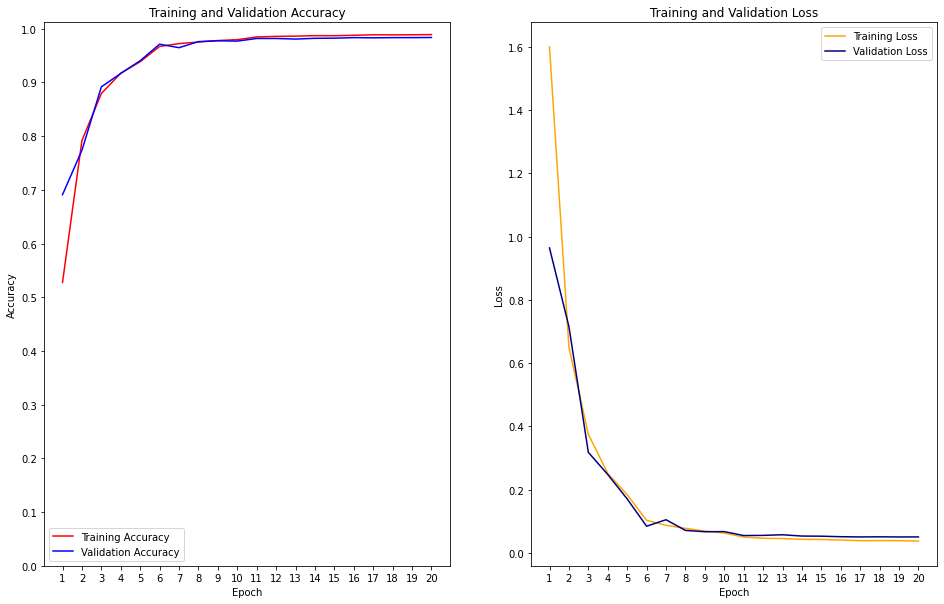

In [ ]:
# Plot Accuracy & Loss
plot_acc_and_loss(history)

### 2. Confusion Matrix

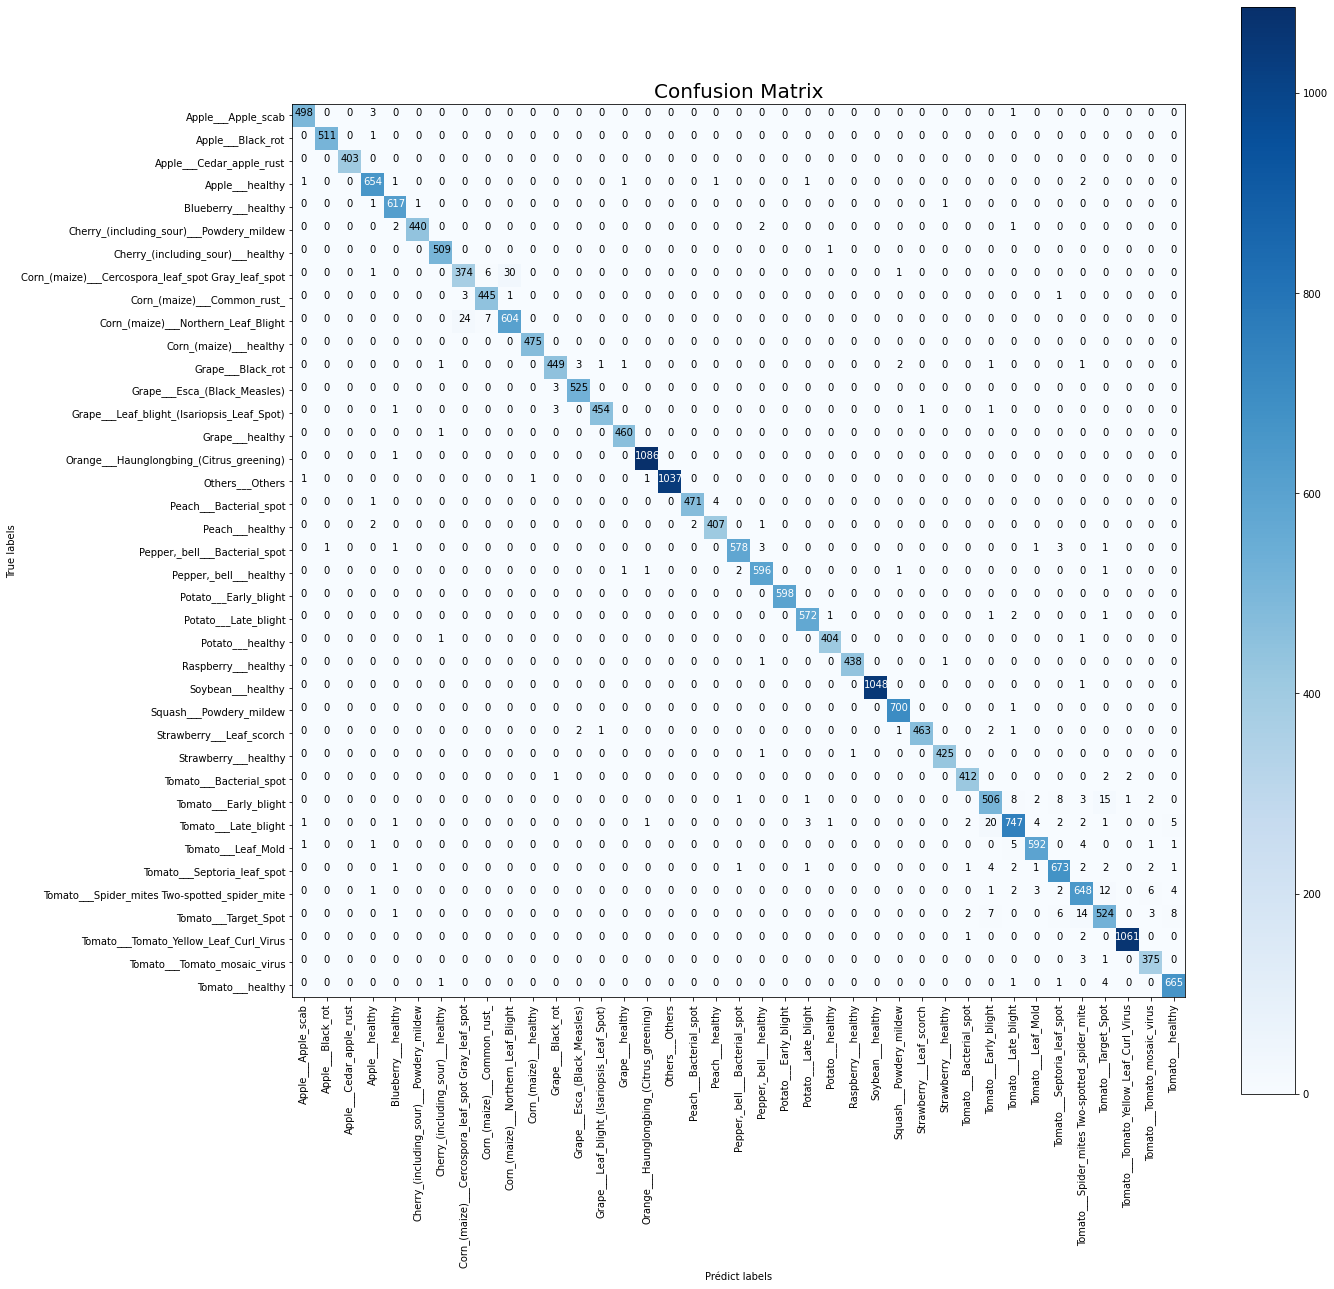

In [ ]:
# Get predictions
predictions_valid = model.predict(dataset_valid)
predictions_valid_int=np.argmax(predictions_valid,axis=1)
# Get Validation datset images and true labels
imgs_valid, labels_valid = unbatchify(dataset_valid)


# Confusion matrix
from sklearn import metrics
import itertools

def Confusion_matrix(label_valid, predictions_class):
  cnf_matrix = metrics.confusion_matrix(label_valid, predictions_class)
  classes = range(0,10)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Confusion Matrix",fontsize=20)
  plt.colorbar()
  tick_marks = np.arange(len(list_class))

  plt.xticks(tick_marks, list_class, rotation='vertical')
  plt.yticks(tick_marks, list_class)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment="center",
              color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Prédict labels')
  plt.show()

Confusion_matrix(labels_valid, predictions_valid_int)

### 3. Predictions from Valid Dataset

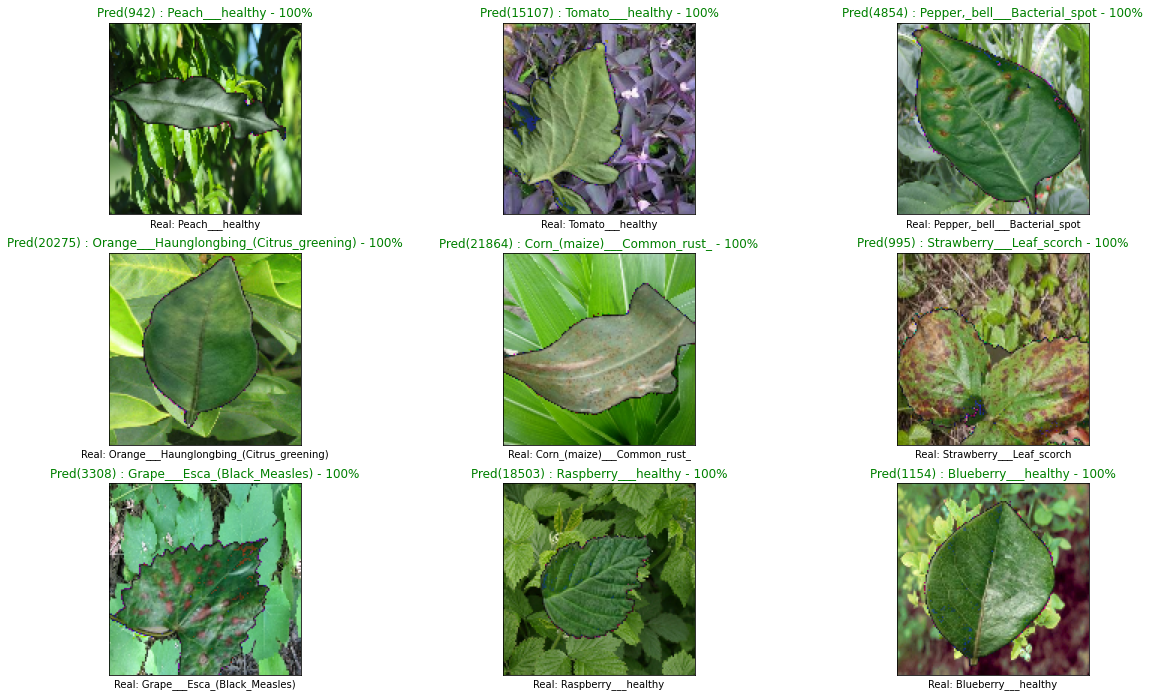

In [ ]:
show_img_and_prediction(model, dataset_valid)

##Evaluate model with Test dataset

In [ ]:
# Unzip Test Datset
!unzip -u "/content/drive/MyDrive/20 - Data/DadaSet_Test_V3.zip" -d "/content/sample_data/dataset_test"

Archive:  /content/drive/MyDrive/20 - Data/DadaSet_Test_V3.zip
   creating: /content/sample_data/dataset_test/Apple___Apple_scab/
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/030bd6ab1e.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/0ad986a780.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/0b6232f0d5.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/16937aab17.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/1bfdac34da.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/1d39f35452.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/23901a45eb.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/2a370f9192.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/2bf593b897.jpg  
  inflating: /content/sample_data/dataset_test/Apple___Apple_scab/2c60d3645a.jpg  
  inflating: /content/sample_data/datase

In [ ]:
TEST_PATH = '/content/sample_data/dataset_test'

# Create Dataframe
def create_info_df(dir_path, test=False):

  list_plants = []
  img_listdir = glob.glob(os.path.join(dir_path, '*'))

  for img_dir in img_listdir:
    plant = img_dir.split('/')[-1]

    for img in os.listdir(img_dir):
      list_plants.append([*plant.split('___'), os.path.join(img_dir,img), plant])

  df = pd.DataFrame(list_plants, columns=['plant', 'category', 'img_path','plant___category'])

  return df

# Get DF
test_info = create_info_df(TEST_PATH, True)
print("Test Info shape: ", test_info.shape)

# Unique label list:
unique_plant_cat = np.unique(test_info['plant___category'].to_numpy())
print("Number of Categories to predict: ", len(unique_plant_cat))
list_class = unique_plant_cat.tolist()

# Label Integer
test_info['label_int'] = test_info['plant___category'].apply(lambda x: list_class.index(x))

Test Info shape:  (1523, 4)
Number of Categories to predict:  39


In [ ]:
test_info['plant___category'].value_counts()

Pepper,_bell___healthy                                60
Potato___Early_blight                                 57
Squash___Powdery_mildew                               55
Grape___Black_rot                                     50
Apple___Apple_scab                                    50
Orange___Haunglongbing_(Citrus_greening)              50
Corn_(maize)___healthy                                50
Cherry_(including_sour)___Powdery_mildew              50
Others___Others                                       50
Blueberry___healthy                                   50
Peach___Bacterial_spot                                50
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot    50
Pepper,_bell___Bacterial_spot                         50
Apple___healthy                                       50
Corn_(maize)___Northern_Leaf_Blight                   50
Corn_(maize)___Common_rust_                           50
Cherry_(including_sour)___healthy                     50
Apple___Cedar_apple_rust       

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/DataScientest/30 - Models/saved_models/20210228-0810-CNN_iteration_2_random_backgrnd_acc-0.984.h5')

In [ ]:
LIST_CLASS_LEN = len(list_class)

def get_label(label_int, list_class=list_class):
  return list_class[np.argmax(label_int)]

def decode_img_test(img_path, label, image_shape=IMG_SHAPE):
  # Read the image file
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, image_shape[:2]) # Resize image to our desired size

  # Transform label integer to one hot vector
  label_one_hot = tf.one_hot(label,depth=LIST_CLASS_LEN)

  # Normalize image (cast float32 and image pixel between 0-1)
  return tf.cast(img, tf.float32)/255, label_one_hot

X, y = test_info['img_path'], test_info['label_int']

print('Creation of the test dataset...')
dataset_test = tf.data.Dataset.from_tensor_slices((X, y))
dataset_test = dataset_test.map(decode_img_test, num_parallel_calls=tf.data.AUTOTUNE)
dataset_test = dataset_test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Creation of the test dataset...


In [ ]:
# Get Validation Loss and Accuracy
val_loss_test, val_acc_test = model.evaluate(dataset_test)
val_acc_test = round(val_acc_test, 3)
print(f'Accuracy for test DataSet: {val_acc_test*100:.2f}%')

48/48 [==============================] - 110s 2s/step - loss: 6.5907 - accuracy: 0.1806
Accuracy for test DataSet: 18.10%


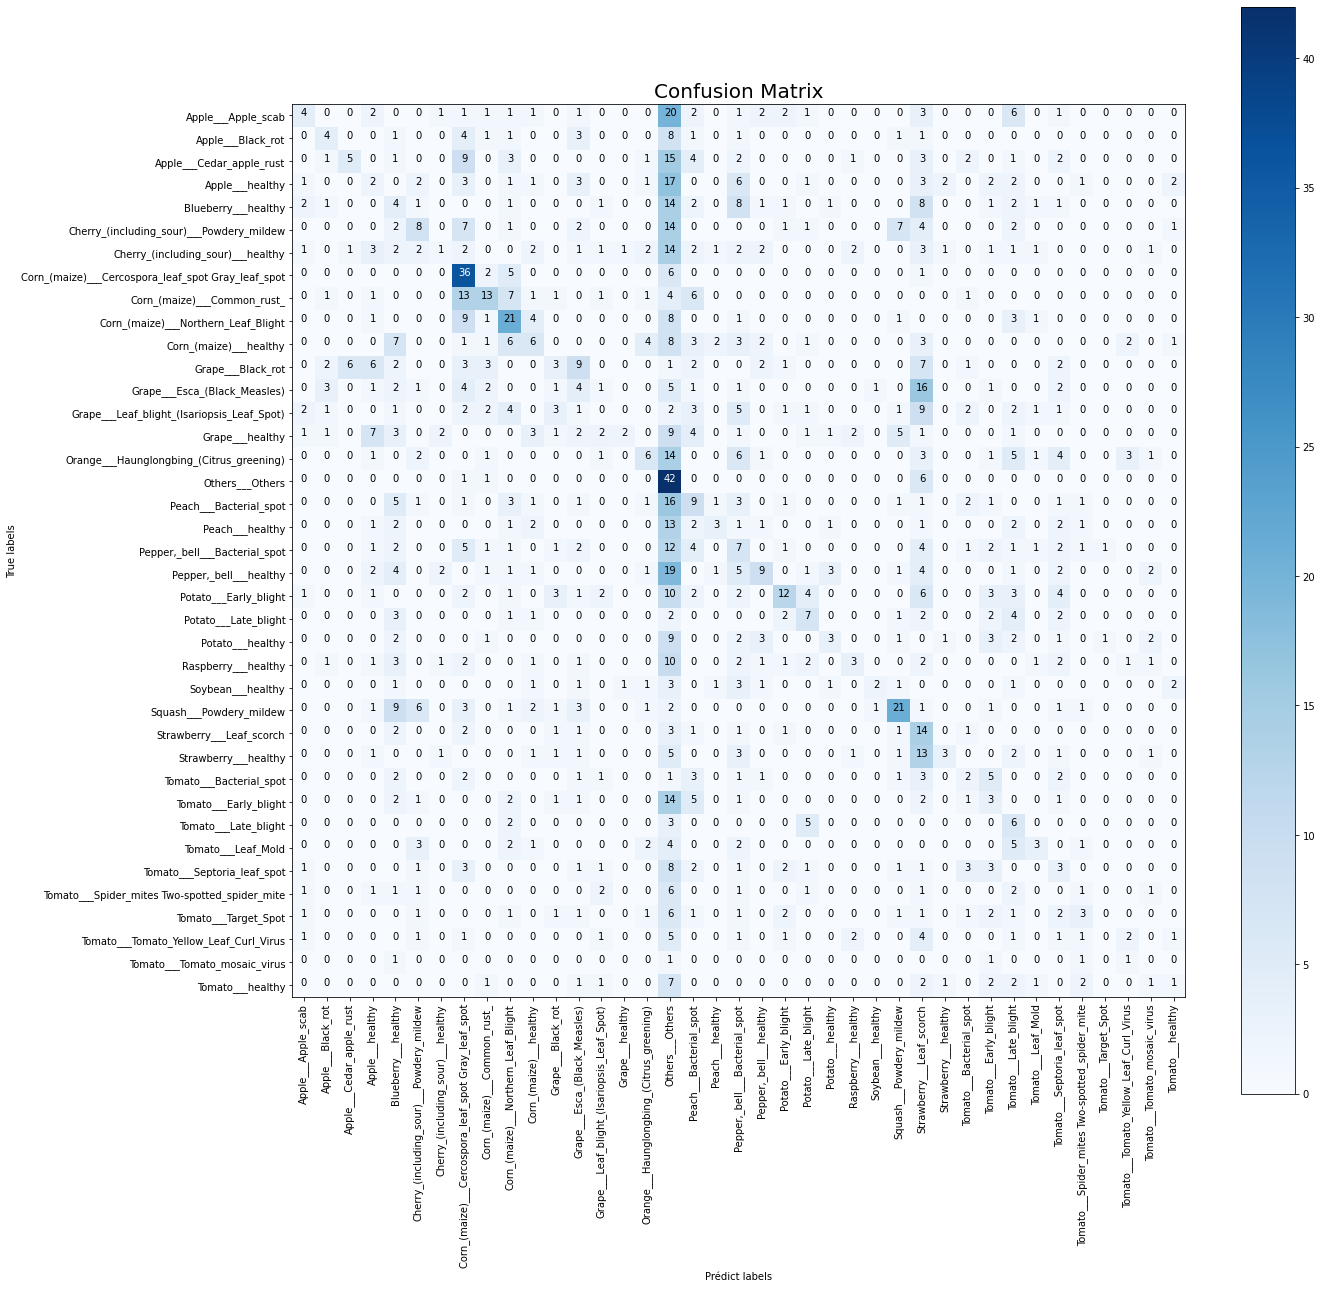

In [ ]:
# Get predictions
predictions_test = model.predict(dataset_test)
predictions_test_int = np.argmax(predictions_test, axis=1)
# Get Validation datset images and true labels
imgs_test, labels_test = unbatchify(dataset_test)

get_confusion_matrix(labels_test, predictions_test_int)